In [ ]:
%matplotlib notebook
from ipywidgets import *
from IPython.display import display, Math

import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg as la
from timeit import default_timer as timer
from datetime import datetime
import itertools
from scipy import sparse, constants, fft
from scipy.sparse import linalg as sla
from matplotlib.ticker import FuncFormatter

Paulis = ((     # maybe make this a function?
    np.array([[1,0],[0,1]]),
    np.array([[0,1],[1,0]]),
    np.array([[0,-1j],[1j,0]]),
    np.array([[1,0],[0,-1]])
    ))


def PauliProduct(v):
    """
    Kronecker product of a sequence of Pauli matrices, indicated by the vector v.
    The output is Paulis[v[0]] \otimes Paulis[v[1]] \otimes ... 
    """
    if len(v)==1:
        return Paulis[v[0]]
    return la.kron(Paulis[v[0]],PauliProduct(v[1:len(v)]))


def pauli_exp(n, angle):
    """
    Exponential of a Pauli matrix: exp(i*angle*Paulis[n])
    """
    return np.cos(angle)*np.eye(2) + 1j*np.sin(angle)*Paulis[n]


def hc(A):
    """
    Hermitian conjugate of a matrix.
    """
    return np.conj(A.T)

def pretty_plot(font_size=None, font_name="CMU Sans Serif", pad=0.3,
                grid=False, cursor=True, ax_linewidth=0.5):
    """
    Some nice settings for pretty plotting with LaTex.
    The plot is made tight with padding set by pad.
    If cursor is true, then mpldatacursor for data selection is activated.
    """
    if font_size is not None:
        plt.rcParams["font.size"] = font_size
    plt.rcParams['font.sans-serif'] = font_name
    # plt.rcParams["text.usetex"] = False
    plt.rcParams["axes.unicode_minus"] = False
    plt.rcParams['axes.linewidth'] = ax_linewidth
    plt.tight_layout(pad=pad)
    if grid: plt.grid()

def piticks(ticks, axis='x', frac=False):
    """
    Set LaTeX-formatted x- or y-ticks and labels matching the given sequence of ticks, as a fraction of pi.
    """    
    labels = []
    for tick in ticks:
        if tick == 0:
            label = '0'
        else:
            tick_frac = Fraction(abs(tick))
            label = '\\pi'
            if tick_frac.numerator != 1:
                label = str(tick_frac.numerator) + label
            if tick_frac.denominator != 1:
                if frac == True:
                    label = '\\frac{' + label + '}{' + str(tick_frac.denominator) + '}'
                else:
                    label = label + '/' + str(tick_frac.denominator)
        if tick < 0:
            label = "-" + label
        labels.append("$" + label + "$")
    if (axis == 'x'):
        ticks_func = plt.xticks
    else:
        ticks_func = plt.yticks
    ticks_func(ticks=ticks, labels=labels)
 
    
def axlim(ax_vec, axis='x'):
    """
    Set xlim or ylim according to the minimum and maximum values of ax_vec.
    """
    lim_vec = [np.min(ax_vec),np.max(ax_vec)]
    if axis == 'x':
        plt.xlim(lim_vec)
    else:
        plt.ylim(lim_vec)

def prfigure(dpi=300, aspect=2/3, multi_col=1):
    plt.figure(figsize=(multi_col*3.375,multi_col*aspect*3.375), dpi=dpi)

def sploweigs(H, num_eigs=2, return_eigenvectors=False):
    return np.sort(sla.eigsh(H, k=num_eigs, sigma=1.02e-80, which='LM',
                             return_eigenvectors=return_eigenvectors))

def get_H_0(Nx, Ny, t, a_SO, mu, PBC_x,
            impurity_loc, impurity_amp, impurity_magnetic):
    hop_x = sparse.kron(sparse.eye(Nx, k=1) + PBC_x*sparse.eye(Nx, k=-Nx+1),
                        sparse.kron(sparse.eye(Ny), -t*sparse.eye(2)) +\
                        sparse.kron(Paulis[0], 1j*a_SO*Paulis[2]) )
    hop_y = sparse.kron(sparse.eye(Nx), sparse.kron(
        sparse.eye(Ny, k=1), -t*sparse.eye(2) - 1j*a_SO*Paulis[1]))
    H_hop = hop_x + hop_y
    H_imp = 0*sparse.eye(Nx*Ny*2)
    for j in range(len(impurity_loc)):
        H_imp += impurity_amp*sparse.kron(sparse.diags(
            (np.arange(Nx) == impurity_loc[j][0]).astype(float)),
            sparse.kron(sparse.diags(
                (np.arange(Ny) == impurity_loc[j][1]).astype(float)),
                Paulis[1 if impurity_magnetic else 0]))
    H_0 = H_hop + hc(H_hop) - (mu - 4*t)*sparse.eye(Nx*Ny*2) + H_imp
    return H_0

def get_H_BdG_three_phases(L_left, L_right, L_1, L_2, L_3, Ny, t, a_SO, mu,
                           Delta, phi_left, phi_right, phi_1, phi_2, phi_3,
                           PBC_x, impurity_amp, impurity_magnetic):
    x_left = L_left - 1
    x_right = L_left + L_1 + L_2 + L_3
    impurity_loc = [[x_left, 0], [x_left,1], [x_right, 0], [x_right, 1]]
    Nx = L_left + L_right + L_1 + L_2 + L_3
    H_0 = get_H_0(Nx, Ny, t, a_SO, mu, PBC_x,
                  impurity_loc, impurity_amp, impurity_magnetic)
    SC_phase = np.concatenate(( np.tile(phi_left, L_left), np.tile(phi_1, L_1),
                           np.tile(phi_2, L_2), np.tile(phi_3, L_3),
                           np.tile(phi_right, L_right) ))
    H_SC = Delta*sparse.kron(sparse.diags(np.exp(1j*SC_phase)),
                         sparse.kron(sparse.eye(Ny), 1j*Paulis[2]))
    return sparse.bmat([[H_0, H_SC], [hc(H_SC), -H_0.T]])

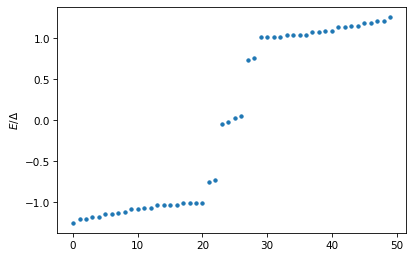

interactive(children=(IntSlider(value=20, description='L_out', max=40, min=5), IntSlider(value=10, description…

In [ ]:
t = 1
a_SO = 0.5
mu = 1.5
PBC_x = 0#1
Delta = 0.6

Ny = 2
L_left = 30
L_right = L_left
L_1 = 2
L_2 = L_1; L_3 = L_1

phi_left = 0
phi_right = 0
phi_1 = 2*np.pi/3
phi_2 = 4*np.pi/3
phi_3 = 6*np.pi/3
# phi_1 = 1; phi_2 = 2; phi_3 = 3

impurity_amp = 0
impurity_magnetic = 0

f = np.cos(phi_1-phi_2) + np.cos(phi_2-phi_3) + np.cos(phi_3-phi_1)
Nx = L_left + L_right + L_1 + L_2 + L_3

def get_energies(L_out, L_seg, impurity_amp=impurity_amp, phi_1=phi_1, phi_2=phi_2, phi_3=phi_3, mu=mu, a_SO=a_SO):
    L_left = L_out; L_right = L_out
    L_1 = L_seg; L_2 = L_seg; L_3 = L_seg
    H_BdG = get_H_BdG_three_phases(
        L_left, L_right, L_1, L_2, L_3, Ny, t, a_SO, mu,
        Delta, phi_left, phi_right, phi_1, phi_2, phi_3,
        PBC_x, impurity_amp, impurity_magnetic)
    E = sploweigs(H_BdG, num_eigs=50)
    return E

E = get_energies(L_left, L_1)
fig = plt.figure(dpi=75)
scat = plt.scatter(range(len(E)), E/Delta, s=10)
plt.ylabel(r'$E/\Delta$')

def update(L_out=20, L_seg=10, impurity_amp=impurity_amp, phi_1=phi_1, phi_2=phi_2, phi_3=phi_3, mu=mu, a_SO=a_SO):
    E = get_energies(L_out, L_seg, impurity_amp=impurity_amp, phi_1=phi_1, phi_2=phi_2, phi_3=phi_3, mu=mu, a_SO=a_SO)
    #line.set_ydata(E_vec/Delta)
    scat.set_offsets(np.column_stack((range(len(E)),E/Delta)))
    fig.canvas.draw_idle()

interact(update, L_out=(5, 40), L_seg=(1, 20), impurity_amp=(-20, 20, 0.1),
         phi_1=(0, 2*np.pi, 0.1), phi_2=(0, 2*np.pi, 0.1), phi_3=(0, 2*np.pi, 0.1),
         mu=(0, 2, 0.1), a_SO=(0, 5, 0.1));